In [27]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Install TensorFlow Decision Forests.
!pip3 install tensorflow_decision_forests --upgrade
import tensorflow_decision_forests as tfdf

from sklearn.model_selection import train_test_split

from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Read Tiles Dataset**

In [28]:
tiles = pd.read_csv(r'/content/drive/MyDrive/capstone/Tiles_expanded.csv')

In [29]:
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
tiles.columns

Index(['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical'],
      dtype='object')

In [34]:
# x: 'Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
#    'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop', 'Collisions_Historical'
# y: 'Collisions_Future'

X = tiles[['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
           'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop', 'Collisions_Historical']]
y = tiles[['Collisions_Future']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

**RANDOM FOREST**

https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [35]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 100, random_state = 0)
regr.fit(X_train, y_train.values.ravel())

y_pred_rf = regr.predict(X_test)[:]

In [36]:
#from sklearn.ensemble import RandomForestClassifier
#from yellowbrick.model_selection import learning_curve

#rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
#print(learning_curve(rfc, X, y, cv=10, scoring='accuracy'))

In [37]:
#dataset = tiles

#tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="label")

In [38]:
model = tfdf.keras.RandomForestModel()

history = model.fit(
    np.asarray(X_train).astype('float32'),
    y_train,
    epochs=1,
    verbose=1,
    validation_split = 0.2)

Use /tmp/tmpujp9wf97 as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.531988. Found 2617 examples.
Training model...
Model trained in 0:00:02.660975
Compiling model...
Model compiled.


In [39]:
print(model.summary())

Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "data:0.11"  0.415683 ################
    2.  "data:0.7"  0.239572 #######
    3.  "data:0.0"  0.182821 ####
    4. "data:0.10"  0.182525 ####
    5.  "data:0.4"  0.133511 #
    6.  "data:0.2"  0.132091 #
    7.  "data:0.5"  0.131010 #
    8.  "data:0.6"  0.128777 #
    9.  "data:0.1"  0.128373 #
   10.  "data:0.3"  0.125823 #
   11.  "data:0.8"  0.108217 
   12.  "data:0.9"  0.100329 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.11" 12

In [40]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    #plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, history.history['loss'].max()])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

In [41]:
history.history

{'num_examples': [2617],
 'accuracy': [0.780664883454337],
 'loss': [1.507511590309064]}

In [42]:

history.history['loss'][0]

1.507511590309064

AttributeError: ignored

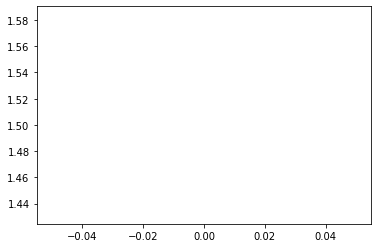

In [43]:
plot_loss(history)

**Decision Tree**